In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()])

In [4]:
full_data = VowelConsonantDataset("../input/train/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=4, shuffle=True)

In [5]:
test_data = VowelConsonantDataset("../input/test/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60,shuffle=False)

In [6]:
classes=full_data.get_classes()
print(classes)


{'C0': 0, 'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5, 'C6': 6, 'C7': 7, 'C8': 8, 'C9': 9, 'V0': 10, 'V1': 11, 'V2': 12, 'V3': 13, 'V4': 14, 'V5': 15, 'V6': 16, 'V7': 17, 'V8': 18, 'V9': 19}


<class 'torch.utils.data.dataloader._DataLoaderIter'>
images shape on batch size = torch.Size([4, 3, 64, 64])
labels shape on batch size = torch.Size([4, 2, 10])


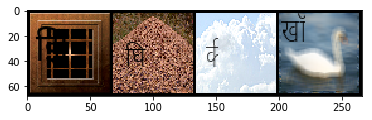

V2 C9
V2 C4
V3 C1
V9 C2


In [7]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))
def labelshow(labels):
    for label in labels:
        x=label.cpu().detach().numpy()
        #print(x[0])
        z=x[0]
        for i in range(x.shape[1]):
            if z[i]==1:
              #  print(i)
                l1=list(classes)[i+10]
                break
        z=x[1]
        for i in range(x.shape[1]):
            if z[i] == 1:
                l2=list(classes)[i]
                break
        print(l1,l2)
labelshow(torchvision.utils.make_grid(labels))





In [9]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [10]:
from torchvision import models

In [16]:
model = models.densenet161(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth


ConnectionError: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /models/densenet161-8d451a50.pth (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f5e4641f518>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))